# __Active learning Regression model__

## Pat Walters note
This tutorial shows how to use active learning to rapidly process a large dataset using a more computationally expensive method like docking, FEP, or 3D similarity calculations.  The code here is a scaled-down version of the code in our paper ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204).  The code is fully functional.  I just removed a few of the options and benchmarks from our original work.  

### Note
We will not be running docking, FEP, etc in this notebook. We will be using a look up oracle on results already obtained.

#### __READ ModAL Documentation while using notebook. You will gain a greater understanding going through the tutorial__

## Requirements fo the noetbook

!pip install pandas numpy seaborn useful_rdkit_utils tqdm scikit-learn modAL-python

In [1]:
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as gp
import useful_rdkit_utils as uru
from modAL.acquisition import BaseLearner, optimizer_PI
from modAL.models import BayesianOptimizer
from modAL.utils.data import modALinput
from modAL.utils.selection import multi_argmax
from rdkit import Chem
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm.auto import tqdm


# enable progress bar
tqdm.pandas()

In [2]:
#Downloading data
url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/active_learning/data/tyk2_fep.csv"
df = pd.read_csv(url)
df.head()

,ligand_id,SMILES,dG_bind,dG_bind_err
0,0,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1c(Cl)cccc1Cl,-2.995,0.455
1,1,O=C(Nc1ccnc(NC(=O)C2CCCC2)c1)c1ccccc1Cl,8.731,0.462
2,2,O=C(Nc1ccnc(NC(=O)C2CCC2)c1)c1ccccc1Cl,3.316,0.448
3,3,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1c(Cl)cc(Cl)cc1Cl,-0.070,0.462
4,4,O=C(Nc1ccnc(NC(=O)C2CC2)c1)c1cc(Cl)ccc1Cl,3.431,0.449


## Defining the Oracle and Kernel function for the ML model

### Pat Walters notes:

**ORACLE**

As with the classification example, we'll define an oracle that looks up values from a dataframe.  In practice, the oracle would perform some more expensive calculation like docking, FEP, or shape overlap. 

**Kernel Function**

When we do active learning, we have to define a machine learning models that acts as a surrogate for the more expensive calculations.  In this case, we're going to use Gaussian Process Regression (GPR) to build our regression models.  To use GPR, we need to define a kernel function. Here we calculate a kernel based on the Tanimoto similarities of the molecules.




In [3]:
class Oracle:
    """
    A class representing an Oracle for active learning regression.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - col_name (str): The name of the column to be used for sampling and retrieving values.
    - invert (bool, optional): Whether to invert the values in the specified column. Defaults to True.

    Methods:
    - sample(num): Randomly samples a specified number of data points from the DataFrame.
    - get_values(idx_list): Retrieves the values from the specified indices in the DataFrame.

    """

    def __init__(self, df, col_name, invert=True):
        self.df = df
        self.col_name = col_name
        if invert:
            self.df[col_name] = self.df[col_name]

    def sample(self, num):
        """
        Randomly samples a specified number of data points from the DataFrame.

        Parameters:
        - num (int): The number of data points to sample.

        Returns:
        - tuple: A tuple containing the sampled fingerprints, values, and indices.

        """
        sample_df = self.df.sample(num)
        return sample_df.fp.values, sample_df[self.col_name].values, sample_df.index
    
    def get_values(self, idx_list):
        """
        Retrieves the values from the specified indices in the DataFrame.

        Parameters:
        - idx_list (list): A list of indices.

        Returns:
        - numpy.ndarray: An array containing the values corresponding to the specified indices.

        """
        return df[self.col_name].values[idx_list]

In [4]:
def calculate_similarity(a, b):
    """
    Calculates the Tanimoto similarity between two arrays.

    Parameters:
    a (numpy.ndarray): The first array.
    b (numpy.ndarray): The second array.

    Returns:
    numpy.ndarray: The Tanimoto similarity between the two arrays.
    """

    # Tanimoto similarity a vs b
    aa = np.sum(a, axis=1, keepdims=True)
    bb = np.sum(b, axis=1, keepdims=True)
    ab = np.matmul(a, b.T)

    return np.true_divide(ab, aa + bb.T - ab)

class TanimotoKernel(gp.kernels.NormalizedKernelMixin,
                     gp.kernels.StationaryKernelMixin,
                     gp.kernels.Kernel):
    """
    TanimotoKernel is a kernel class that calculates the Tanimoto similarity between two sets of data points.

    Parameters:
    -----------
    None

    Methods:
    --------
    __call__(X, Y=None, eval_gradient=False):
        Calculates the Tanimoto similarity between the input data points X and Y.

        Parameters:
        -----------
        X : array-like of shape (n_samples_X, n_features)
            The first set of data points.

        Y : array-like of shape (n_samples_Y, n_features), default=None
            The second set of data points. If None, Y is set to X.

        eval_gradient : bool, default=False
            Whether to evaluate the gradient of the Tanimoto similarity. This parameter is not used in this implementation.

        Returns:
        --------
        similarity : array-like of shape (n_samples_X, n_samples_Y)
            The Tanimoto similarity matrix between X and Y.
    """

    def __init__(self):
        pass

    def __call__(self, X, Y=None, eval_gradient=False):
        assert not eval_gradient
        if Y is None:
            Y = X

        return calculate_similarity(X, Y)

/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


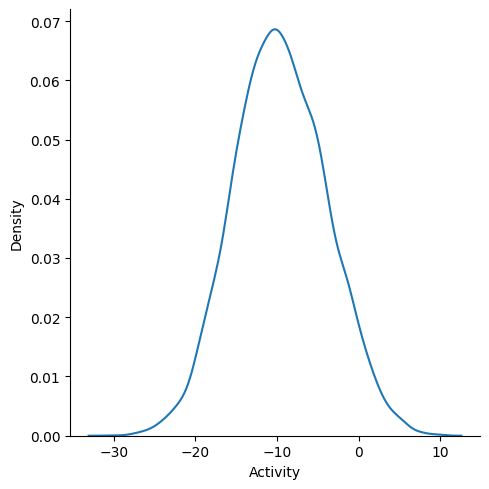

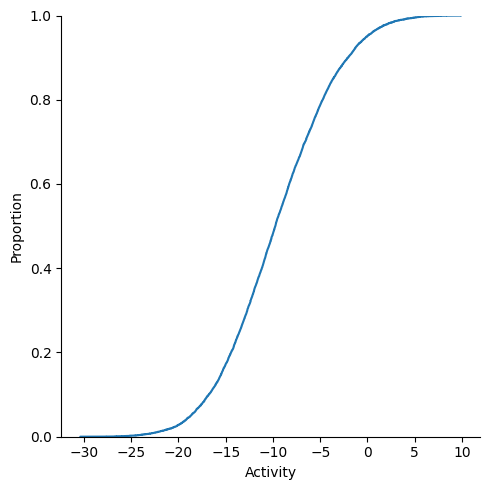

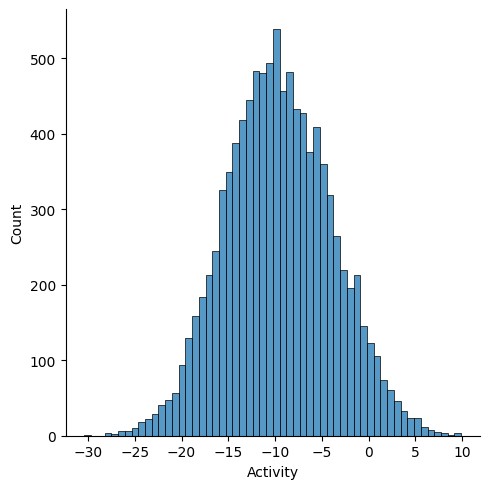

In [5]:
# Converting th kca/mol to pKd and making a new column
df["Activity"] = -np.log10(np.exp(df.dG_bind/0.5961)/1e-6)

# Plotting the distribution of the activity column
sns.displot(df, x="Activity", kind="kde")
sns.displot(df, x="Activity", kind="ecdf")
sns.displot(df, x="Activity", kind="hist")

## Setting up for ML

1. Generate rdkit molecule

2. Generate fingerprints

3. Create a pool for fingerprints for the AL algorithm

In [6]:
# Generate rdkit_mol
df["rdkit_mol"] = df.SMILES.progress_apply(Chem.MolFromSmiles)

# Generate Fingerprints
df["fp"] = df.rdkit_mol.progress_apply(uru.mol2numpy_fp)

# Create pool of fp for AL
X_pool = np.stack(df.fp.values)

  0%|          | 0/9997 [00:00<?, ?it/s]

  0%|          | 0/9997 [00:00<?, ?it/s]

## Define Helper Function for AL

## Pat Walters Notes

For the greedy search, we want to select the best scoring molecules, but we want to avoid selecting the same molecules multiple times. This function accepts a list of predictions and does the following.

- Sort by score

- Remove the molecules that were previously selected

- Return the top **n_to_choose**

In [7]:
# Defining the helper function

def find_best_index(predicted, used, num_to_choose):
    """
    Finds the indices of the top `num_to_choose` elements in the `predicted` list that have not been used.

    Args:
        predicted (list): A list of predicted values.
        used (list): A list of indices that have already been used.
        num_to_choose (int): The number of indices to choose.

    Returns:
        list: A list of the top `num_to_choose` indices that have not been used.
    """
    # Getting index list
    tmp_list = list(enumerate(predicted))
    # Sorting the list based on the second item (index 1) in the list
    tmp_list.sort(key=itemgetter(1), reverse=True)
    # Selecting the top num_to_choose that has not been used
    tmp_list = [x for x in tmp_list if x[0] not in used]
    # Selecting the top num_to_choose
    tmp_list = [x[0] for x in tmp_list]
    # Returning the top num_to_choose
    return tmp_list[:num_to_choose]


## Pat Walters notes:
Acquistion functions:  

The first **greedy** simply selects the **n** top scoring molecules to be evaluated by the oracle.  

The second **maximize_PI** maximizes the Probability of Improvement (PI) and uses uncertainty and the scores to balance exploration and exploitation.  

The git repo associated with our paper ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204) has examples of several other acquistion functions.  TLDR from our work, the acquistion function doesn't make a huge difference. 

In [8]:
# Defining the greedy acquisition function

def greedy(optimizer: BaseLearner, X: modALinput, n_instances=1, used=[]):
    """
    Selects the next instance(s) to query using a greedy strategy.

    Args:
        optimizer (BaseLearner): The active learning model used for prediction.
        X (modALinput): The input data.
        n_instances (int, optional): The number of instances to select. Defaults to 1.
        used (list, optional): A list of indices of instances that have already been used. Defaults to an empty list.

    Returns:
        tuple: A tuple containing the index of the best instance(s) and the corresponding value(s).
    """
    
    # predicting the results from the optimizer
    results = optimizer.predict(X)
    # finding the best index
    best_index = find_best_index(results, used, n_instances)
    # returning the best index and the value
    return best_index, X[best_index]

# Defining the aqcuisition function that maximizes the Probability of Improvement (PI)
def maximize_PI(optimizer: BaseLearner, 
        X: modALinput, 
        tradeoff: float = 0, 
        n_instances: int = 1, 
        used=[],
        cycles = -1) -> np.ndarray:
    """
    Finds the maximum probability of improvement (PI) and returns the best index and its corresponding value.

    Parameters:
    - optimizer (BaseLearner): The optimizer used for calculating the probability of improvement.
    - X (modALinput): The input data.
    - tradeoff (float): The tradeoff parameter for PI calculation. Default is 0.
    - n_instances (int): The number of molecules to select for each ML cycle. Default is 1.
    - used (list): A list of indices that have already been used. Default is an empty list.
    - cycles (int): The number of cycles to run. Default is -1, which means infinite cycles.

    Returns:
    - tuple: A tuple containing the best index and its corresponding value.
    """
    # optimizer calculating the probability of improvement 
    pi = optimizer_PI(optimizer, X, tradeoff=tradeoff)

    # finding the best index
    best_index = find_best_index(pi, used, n_instances)

    # returning the best index and the value
    return best_index, X[best_index]



In [9]:
# Create an oracle
activity_column = "Activity"
oracle = Oracle(df, activity_column)


## Running and evaluating the Active Learning model

In [10]:
# Run AL Loop

# Selecting number of molecules to use to train model for each cycle
n_instances = 200

# Selecting number of cycles
n_cycles = 10

# defining the acqusition function to be used. greedy or max_PI
query_strategy = maximize_PI

# oracle.sample returns fingerprints, values and indices for the specified number of molecules
# The database and activity column is in the oracle class that is automatically executed when calling orcale
X_init, y_init, sample_index = oracle.sample(n_instances)

# Creating a Gaussian Process Regressor
optimizer = BayesianOptimizer(estimator=GaussianProcessRegressor(kernel=TanimotoKernel()),
                              X_training=np.stack(X_init), 
                              y_training=y_init,
                              query_strategy=query_strategy)

#initialize the score list for values predicted
val_list = [y_init]

# saving the used indices on a list
used = list(sample_index)

# running the active learning loop
for i in tqdm(range(0, n_cycles)):
    # query optimizaer for next set of molecules
    # Input:The query function needs X_pool and then any number of parameters required 
    # from the query stradegy variable you initiated
    # Output: The molecule index and the corresponding values
    query_index, query_desc = optimizer.query(X_pool, 
                                              n_instances=n_instances, 
                                              used=used)
    
    # Get values from the oracle (which is a look up function). 
    # Generally this is where docking or something will be executed
    # Getting the molecules corresponding values
    vals = oracle.get_values(query_index)

    # Saving the values in the value list
    val_list.append(vals)

    # Updating the used molecule indices in the used list
    used += query_index

    # Updating the optimizer with new values which is agglomerated to the previous database
    optimizer.teach(query_desc, vals)





  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
used

[9123,
 7507,
 2937,
 8873,
 5803,
 9857,
 3588,
 2379,
 553,
 5025,
 6315,
 9832,
 8508,
 186,
 4570,
 5362,
 6042,
 3875,
 4960,
 3042,
 3261,
 3672,
 9490,
 1466,
 9481,
 8699,
 9950,
 1722,
 8507,
 2005,
 7264,
 2527,
 6361,
 7171,
 2556,
 2025,
 7579,
 367,
 5338,
 8421,
 588,
 8249,
 8703,
 6007,
 9370,
 5457,
 7802,
 9613,
 1818,
 773,
 5272,
 2263,
 796,
 4714,
 1482,
 3618,
 8828,
 4629,
 3585,
 804,
 5993,
 9019,
 5734,
 9439,
 3389,
 8980,
 9091,
 9618,
 8595,
 9204,
 1734,
 9341,
 8322,
 1130,
 9752,
 2657,
 157,
 3628,
 2254,
 9350,
 2061,
 7654,
 4152,
 2465,
 3800,
 3054,
 1969,
 9748,
 6498,
 8675,
 7539,
 2257,
 8116,
 6905,
 8496,
 2491,
 8926,
 4498,
 7877,
 1684,
 7067,
 5470,
 1717,
 5315,
 9292,
 1294,
 8101,
 543,
 3720,
 1153,
 8808,
 2700,
 3274,
 1784,
 1651,
 6512,
 4477,
 6961,
 7517,
 288,
 1954,
 6943,
 5772,
 3761,
 4963,
 2725,
 3318,
 5713,
 8570,
 3328,
 1451,
 2591,
 962,
 385,
 8528,
 398,
 8304,
 8670,
 3673,
 698,
 3563,
 9322,
 370,
 3414,
 5438,


hit rate in the top 0 of entire database tested: 0.00 %
hit rate in the top 100 of entire database tested: 4.00 %
hit rate in the top 200 of entire database tested: 7.23 %
hit rate in the top 300 of entire database tested: 10.41 %
hit rate in the top 400 of entire database tested: 13.36 %
hit rate in the top 500 of entire database tested: 15.77 %
hit rate in the top 600 of entire database tested: 18.32 %
hit rate in the top 700 of entire database tested: 20.64 %
hit rate in the top 800 of entire database tested: 22.45 %
hit rate in the top 900 of entire database tested: 24.55 %
hit rate in the top 1000 of entire database tested: 26.32 %
hit rate in the top 1100 of entire database tested: 28.23 %
hit rate in the top 1200 of entire database tested: 29.82 %
hit rate in the top 1300 of entire database tested: 31.36 %
hit rate in the top 1400 of entire database tested: 33.00 %
hit rate in the top 1500 of entire database tested: 34.50 %
hit rate in the top 1600 of entire database tested: 35.

/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Hit rate (%)')

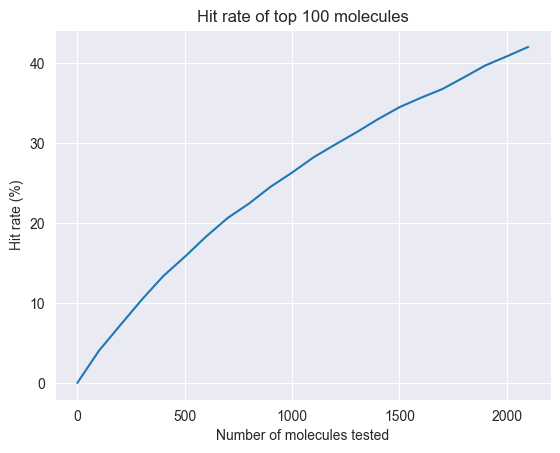

In [11]:
# Making a loop to save the hits for every 100 additional molecules tested
hit_list = []

for i in range(0, 2200, 100):
    reference_df = df.sort_values(activity_column, ascending=False).head(i).copy()
    pick_df = df.iloc[used].sort_values(activity_column, ascending=False).head(i).copy()
    x = len(reference_df.merge(pick_df, on="ligand_id"))
    hit = x / len(df.iloc[used]) * 100
    hit_list.append(hit)
    
    print(f"hit rate in the top {i} of entire database tested:", f"{hit:.2f} %")

# Plotting the results using seaborn
sns.set_style("darkgrid")
g = sns.lineplot(x=range(0, 2200, 100), y=hit_list)
g.set_title("Hit rate of top 100 molecules")
g.set_xlabel("Number of molecules tested")
g.set_ylabel("Hit rate (%)")

In [12]:
# Analyzing the results

# Determining the number of molecules found in the topp 100.
# Activity column is the pKd value
reference_df_100 = df.sort_values(activity_column, ascending=False).head(100).copy()
reference_df_all = df.sort_values(activity_column, ascending=False).head(len(df.iloc[used])).copy()
# Create a new dataframe with the selected molecules and sort by score
# The used variabe comes from the active learning loop. It kept track of all the molecules used in the AL loop
pick_df_100 = df.iloc[used].sort_values(activity_column, ascending=False).head(100).copy()
pick_df_all = df.iloc[used].sort_values(activity_column, ascending=False).copy()

# merge dataframes to determine the number of molecules that are in common
print("Number of molecules found in the top 100:", len(reference_df_100.merge(pick_df_100, on="ligand_id")))
print("Number of molecules found in the entire database tested:", len(reference_df_all.merge(pick_df_all, on="ligand_id")))

hit_100 =len(reference_df_100.merge(pick_df_100, on="ligand_id"))
hit_all = len(reference_df_all.merge(pick_df_all, on="ligand_id"))

print("hit rate in the top 100 of entire database tested:", f"{(hit_100 / len(df.iloc[used]) * 100):.2f} %")
print("hit rate in the entire database tested:", f"{(hit_all / len(df.iloc[used]) * 100):.2f} %")


Number of molecules found in the top 100: 88
Number of molecules found in the entire database tested: 951
hit rate in the top 100 of entire database tested: 4.00 %
hit rate in the entire database tested: 43.23 %


In [13]:
# Analyzing the results across the AL cycles

# Add data into a dataframe
results_list = []

# Loop over the number of cycles using the predicted value list
for index, v in enumerate(val_list):
    results_list += [(index, x) for x in v]

# Create the dataframe with the cycle number and the actual value
results_df = pd.DataFrame(results_list, columns=["cycle", activity_column])

# Adding a rows for the number of molecules used
results_df["molecule_idx"] = used

# Adding the SMILES from the original dataframe that match the used molecule index
results_df['SMILES'] = df['SMILES'].values[used]

# reorder the columns in results_df
results_df = results_df[["SMILES", "cycle", "molecule_idx", "Activity"]]
results_df

,SMILES,cycle,molecule_idx,Activity
0,CCc1cc(Nc2cc(NC(=O)c3cc(O)ccc3Cl)ccn2)nc(N2CCC...,0,6810,2.660390
1,Nc1ccc(F)c(C(=O)Nc2ccnc(NC(=O)C3CCOC3)c2)c1,0,2667,-11.284973
2,Cc1ccc(C(=O)Nc2ccnc(Nc3ccc(C#N)cn3)c2)c(Cl)c1,0,7270,-14.064428
3,CCNC(=O)Nc1cc(NC(=O)c2c(Cl)cc(C)cc2Cl)ccn1,0,2902,-10.180476
4,O=C(Nc1ccnc(Nc2cnn(C3CCOCC3)c2)c1)c1cccc(Cl)c1F,0,5038,0.596380
...,...,...,...,...
2195,Nc1cccc(C(=O)Nc2ccnc(NC(=O)C3CC3CO)c2)c1Cl,10,1108,-12.323899
2196,Cc1ccc(C(=O)Nc2ccnc(NC(=O)C3CC3C#N)c2)c(Cl)c1,10,1109,-10.241675
2197,O=C(CC1CC1)Nc1cc(NC(=O)c2ccc(Cl)cc2Cl)ccn1,10,1110,-11.250730
2198,Nc1cccc(F)c1C(=O)Nc1ccnc(NC(=O)C2CC2F)c1,10,1111,-12.669965


Text(0.5, 0, 'AL Cycle')

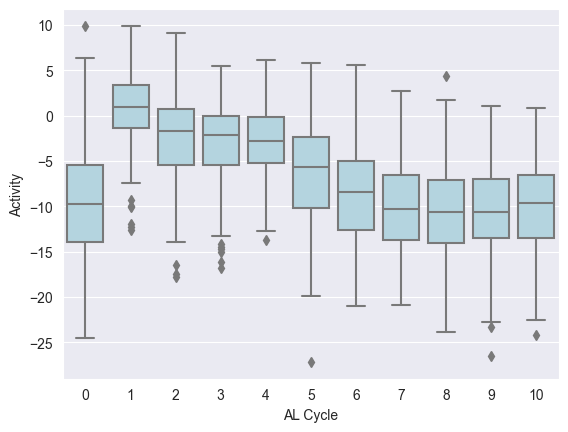

In [14]:
# Plotting the scores of the molecules for each cycle. First cycle is randomly selected
ax = sns.boxplot(x="cycle", y=activity_column, data=results_df, color="lightblue")
ax.set_xlabel("AL Cycle")

Text(0, 0.5, 'Activity')

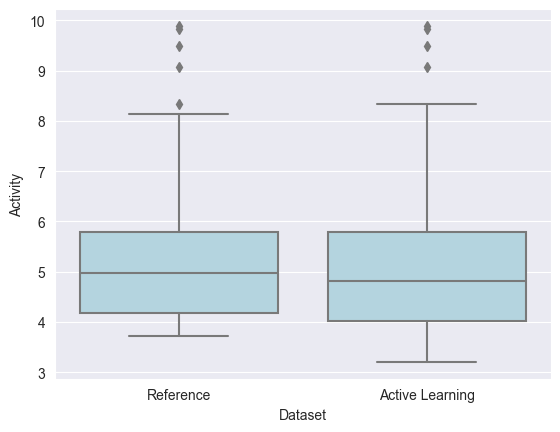

In [15]:
# Distribution of the top 100 true values vs the predicted values
# Get a dataframe with the top 100 reference molecules
ref_top_100 = df.sort_values("Activity",ascending=False).head(100).copy()
ref_top_100['Dataset'] = 'Reference'
# Get a dataframe with top 100 molecules predicted by active learning
pred_top_100 = results_df.sort_values("Activity",ascending=False).head(100).copy()
pred_top_100['Dataset'] = 'Active Learning'
# Make a boxplot comparing the scores of the top 100 molecules
ax = sns.boxplot(x="Dataset", y="Activity", data=pd.concat([ref_top_100,pred_top_100]),color="lightblue");
ax.set_ylabel("Activity")

In [16]:
# Run AL Loop using greedy acqusition function

# Selecting number of molecules to use to train model for each cycle
n_instances = 200

# Selecting number of cycles
n_cycles = 10

# defining the acqusition function to be used. greedy or max_PI
query_strategy = greedy

# oracle.sample returns fingerprints, values and indices for the specified number of molecules
# The database and activity column is in the oracle class that is automatically executed when calling orcale
X_init, y_init, sample_index = oracle.sample(n_instances)

# Creating a Gaussian Process Regressor
optimizer = BayesianOptimizer(estimator=GaussianProcessRegressor(kernel=TanimotoKernel()),
                              X_training=np.stack(X_init), 
                              y_training=y_init,
                              query_strategy=query_strategy)

#initialize the score list for values predicted
val_list = [y_init]

# saving the used indices on a list
used = list(sample_index)

# running the active learning loop
for i in tqdm(range(0, n_cycles)):
    # query optimizaer for next set of molecules
    # Input:The query function needs X_pool and then any number of parameters required 
    # from the query stradegy variable you initiated
    # Output: The molecule index and the corresponding values
    query_index, query_desc = optimizer.query(X_pool, 
                                              n_instances=n_instances, 
                                              used=used)
    
    # Get values from the oracle (which is a look up function). 
    # Generally this is where docking or something will be executed
    # Getting the molecules corresponding values
    vals = oracle.get_values(query_index)

    # Saving the values in the value list
    val_list.append(vals)

    # Updating the used molecule indices in the used list
    used += query_index

    # Updating the optimizer with new values which is agglomerated to the previous database
    optimizer.teach(query_desc, vals)


  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# Analyzing the results

# Determining the number of molecules found in the topp 100.
# Activity column is the pKd value
reference_df_100 = df.sort_values(activity_column, ascending=False).head(100).copy()
reference_df_all = df.sort_values(activity_column, ascending=False).head(len(df.iloc[used])).copy()
# Create a new dataframe with the selected molecules and sort by score
# The used variabe comes from the active learning loop. It kept track of all the molecules used in the AL loop
pick_df_100 = df.iloc[used].sort_values(activity_column, ascending=False).head(100).copy()
pick_df_all = df.iloc[used].sort_values(activity_column, ascending=False).copy()

# merge dataframes to determine the number of molecules that are in common
print("Number of molecules found in the top 100:", len(reference_df_100.merge(pick_df_100, on="ligand_id")))
print("Number of molecules found in the entire database tested:", len(reference_df_all.merge(pick_df_all, on="ligand_id")))

hit_100 =len(reference_df_100.merge(pick_df_100, on="ligand_id"))
hit_all = len(reference_df_all.merge(pick_df_all, on="ligand_id"))

print("hit rate in the top 100 of entire database tested:", f"{(hit_100 / len(df.iloc[used]) * 100):.2f} %")
print("hit rate in the entire database tested:", f"{(hit_all / len(df.iloc[used]) * 100):.2f} %")

Number of molecules found in the top 100: 93
Number of molecules found in the entire database tested: 1598
hit rate in the top 100 of entire database tested: 4.23 %
hit rate in the entire database tested: 72.64 %


hit rate in the top 0 of entire database tested: 0.00 %
hit rate in the top 100 of entire database tested: 4.23 %
hit rate in the top 200 of entire database tested: 8.64 %
hit rate in the top 300 of entire database tested: 12.91 %
hit rate in the top 400 of entire database tested: 17.14 %
hit rate in the top 500 of entire database tested: 21.41 %
hit rate in the top 600 of entire database tested: 25.55 %
hit rate in the top 700 of entire database tested: 29.32 %
hit rate in the top 800 of entire database tested: 32.86 %
hit rate in the top 900 of entire database tested: 36.50 %
hit rate in the top 1000 of entire database tested: 40.23 %
hit rate in the top 1100 of entire database tested: 43.82 %
hit rate in the top 1200 of entire database tested: 47.36 %
hit rate in the top 1300 of entire database tested: 50.41 %
hit rate in the top 1400 of entire database tested: 53.68 %
hit rate in the top 1500 of entire database tested: 56.59 %
hit rate in the top 1600 of entire database tested: 59.

/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Hit rate (%)')

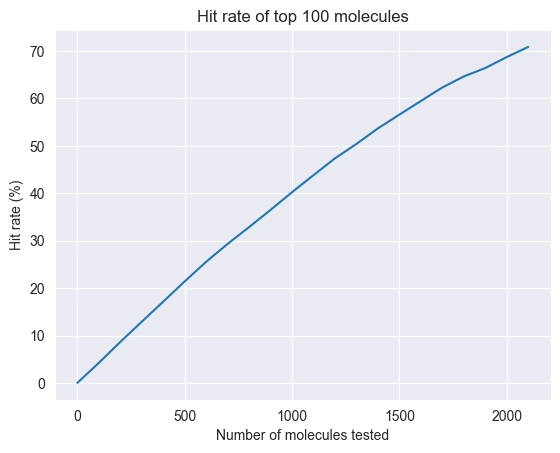

In [18]:
# Making a loop to save the hits for every 100 additional molecules tested
hit_list = []

for i in range(0, 2200, 100):
    reference_df = df.sort_values(activity_column, ascending=False).head(i).copy()
    pick_df = df.iloc[used].sort_values(activity_column, ascending=False).head(i).copy()
    x = len(reference_df.merge(pick_df, on="ligand_id"))
    hit = x / len(df.iloc[used]) * 100
    hit_list.append(hit)
    
    print(f"hit rate in the top {i} of entire database tested:", f"{hit:.2f} %")

# Plotting the results using seaborn
sns.set_style("darkgrid")
g = sns.lineplot(x=range(0, 2200, 100), y=hit_list)
g.set_title("Hit rate of top 100 molecules")
g.set_xlabel("Number of molecules tested")
g.set_ylabel("Hit rate (%)")


Text(0.5, 0, 'AL Cycle')

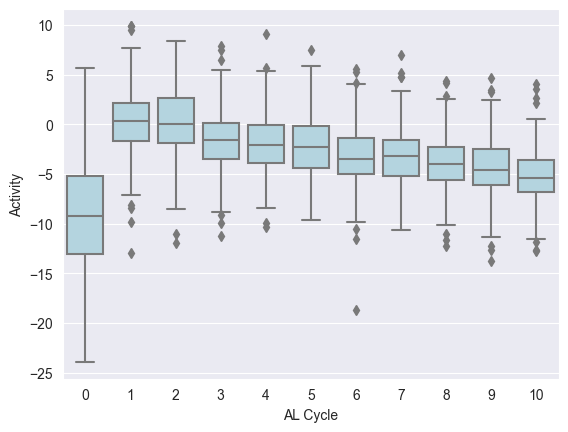

In [19]:
# Analyzing the results across the AL cycles

# Add data into a dataframe
results_list = []

# Loop over the number of cycles using the predicted value list
for index, v in enumerate(val_list):
    results_list += [(index, x) for x in v]

# Create the dataframe with the cycle number and the actual value
results_df = pd.DataFrame(results_list, columns=["cycle", activity_column])

# Adding a rows for the number of molecules used
results_df["molecule_idx"] = used

# Adding the SMILES from the original dataframe that match the used molecule index
results_df['SMILES'] = df['SMILES'].values[used]

# reorder the columns in results_df
results_df = results_df[["SMILES", "cycle", "molecule_idx", "Activity"]]

# Plotting the scores of the molecules for each cycle. First cycle is randomly selected
ax = sns.boxplot(x="cycle", y=activity_column, data=results_df, color="lightblue")
ax.set_xlabel("AL Cycle")




Text(0, 0.5, 'Activity')

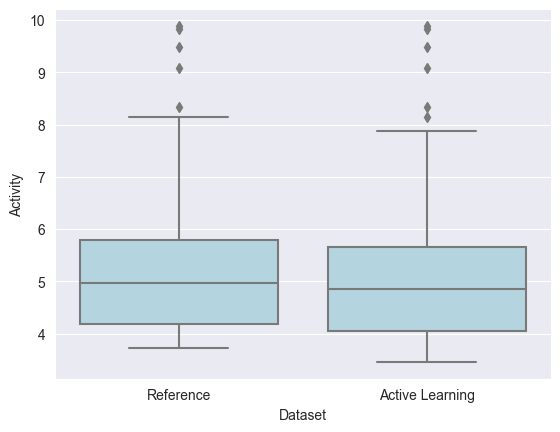

In [20]:
# Distribution of the top 100 true values vs the predicted values
# Get a dataframe with the top 100 reference molecules
ref_top_100 = df.sort_values("Activity",ascending=False).head(100).copy()
ref_top_100['Dataset'] = 'Reference'
# Get a dataframe with top 100 molecules predicted by active learning
pred_top_100 = results_df.sort_values("Activity",ascending=False).head(100).copy()
pred_top_100['Dataset'] = 'Active Learning'
# Make a boxplot comparing the scores of the top 100 molecules
bx = sns.boxplot(x="Dataset", y="Activity", data=pd.concat([ref_top_100,pred_top_100]),color="lightblue");
bx.set_ylabel("Activity")

Text(0, 0.5, 'Activity')

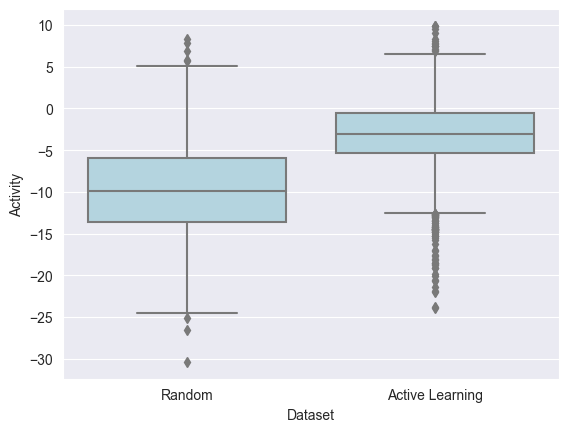

In [21]:
# Take a random sample from the input data that is the same size as the dataframe with the selected molecules
random_df = df.sample(len(results_df)).copy()
random_df['Dataset'] = 'Random'
# Label the active learning data
results_df['Dataset'] = 'Active Learning'
ax = sns.boxplot(x="Dataset", y="Activity", data=pd.concat([random_df,results_df]),color="lightblue");
ax.set_ylabel("Activity")